# TimeSeries Mooring Data - Quick Plot

From an erddap Dataset, specify the Mooring ID to get a quick plot of the data

In [159]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

In [160]:
server_url = 'http://ecofoci-field.pmel.noaa.gov:8082/erddap'
dataset_name = 'datasets_Mooring_23kum3a_preliminary'
e = ERDDAP(server=server_url,
          protocol='tabledap',
          response='csv')

e.dataset_id=dataset_name

pdf = e.to_pandas(
            index_col='time (UTC)',
            parse_dates=True,
            skiprows=(1,)  # units information can be dropped.
        )
# pdf

## Export to CSV - via pandas

In [161]:
variable = 'salinity (PSU)'
variable = 'temperature'

for g, group in pdf.groupby('depth (m)'):
    if len(group[variable].dropna(how='all')) != 0:
        group[variable].to_csv(f'{dataset_name}_{variable}.{g}m.csv')

## Perform 35hr Lanzcos Filter and export data

A common filter to apply to the hourly data is a 35hr Lanzcos Lowpass filter

In [162]:
import EcoFOCIpy.math.lanzcos as lanzcos #<- instrument specific
import matplotlib.pyplot as plt

23kum3a_s37_0001m
23kum3a_s37_0020m


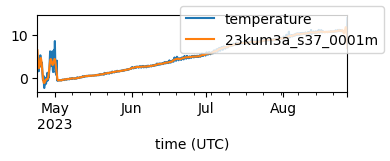

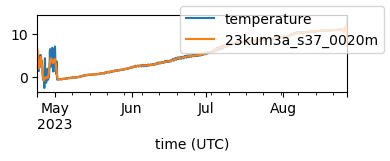

In [163]:
for g, dft in pdf.groupby('depth (m)'):
    if len(dft[variable].dropna(how='all')) != 0:
        print(dft.iloc[0]['timeseries_id'])
        #
        ## missing data fill limited by number of hours to linearly interpolate
        temp = dft[variable].interpolate(method='time',limit=6)

        # get index of missing data that wasn't filled
        # the remaining missing data will continue to be missing after analysis
        # this data and the edges of the timeseries need to have the effects of the filter window accounted for

        missing_index = np.isnan(temp)
        temp = dft[variable].interpolate(method='time')

        #address gaps at beginning and end... back fill... and forward fill at end... 
        # the filter window will correct small gaps at the tails but will become worse as the leading gaps get bigger
        temp.bfill(inplace=True)
        temp.ffill(inplace=True)

        #filter data with lanzcos filter
        lanzcosfiltered = lanzcos.lanzcos(temp.values,1,35) + dft[variable].mean()
        lanzcosfiltered[missing_index] = np.nan

        fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(4,1), sharex=True)
        temp.plot(ax=axes)
        (temp *0 + lanzcosfiltered).plot(ax=axes,label=dft.iloc[0]['timeseries_id'])
        fig.legend()
        (temp *0 + lanzcosfiltered).to_csv(f'{dataset_name}_{variable}_35hr.{g}m.csv')
        

In [164]:
## plot top and bottom
%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker


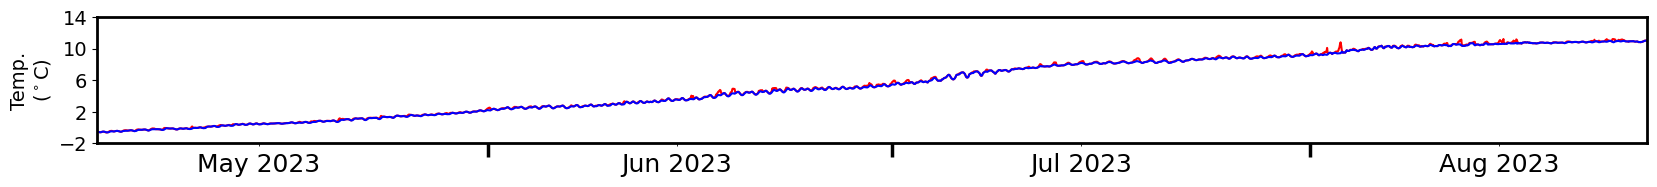

In [165]:
fig, ax = plt.subplots(1,figsize=(20, 2))

# ax[0].scatter(htcon_anom.time,htcon_anom,s=10,c=htcon_anom, cmap=cm.cm.balance)

# for year in icedf.drop(['day_of_year'],axis=1).columns:
#     ax[1].plot([datetime.datetime.strptime(f'{year} {x}','%Y %j') for x in icedf.day_of_year], icedf[year],c=(120/255,23/255,154/255),alpha=0.75)
for g,gr in pdf.groupby('depth (m)'):
    if gr['depth (m)'].iloc[0] == pdf['depth (m)'].max():
        plt.plot(gr.index,gr.temperature,color='b')
    if gr['depth (m)'].iloc[0] == pdf['depth (m)'].min():
        plt.plot(gr.index,gr.temperature,color='r')
ax.set_ylabel('Temp.\n($^\circ$C)',fontsize=14)

# ax[0].fill_between(hr_chlor['chlorophyll_fluorescence'].index, -1, 10, where=hr_chlor['category'] == 2,
#                 facecolor='green', alpha=0.875)
# ax[0].fill_between(hr_chlor['chlorophyll_fluorescence'].index, -1, 10, where=hr_chlor['category'] == 1,
#                 facecolor='green', alpha=0.125)
# ax[0].fill_between(hr_chlor['chlorophyll_fluorescence'].index, -1, 10, where=np.isnan(hr_chlor['category']),
#                 facecolor='grey', alpha=0.125)
# ax[0].fill_between(pd.date_range(start='1/1/2021', end='1/01/2022'), -1, 10,
#                 facecolor='grey', alpha=0.125)
# ax[0].fill_between(pd.date_range(start='6/1/2005', end='10/01/2007'), -1, 10,
#                 facecolor='grey', alpha=0.125)
# ax[2].set_ylim([0,.2])

[x.set_linewidth(2.0) for x in ax.spines.values()]
ax.set_xlim([datetime.date(2023,5,3),datetime.date(2023,8,26)])
ax.set_ylim([0,14])

ax.yaxis.set_ticks(range(-2,16,4))
ax.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax.xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_formatter(DateFormatter('%b %Y'))
ax.xaxis.set_major_formatter(DateFormatter(''))
ax.yaxis.set_tick_params(which='major',labelsize=14)
ax.xaxis.set_tick_params(which='major', pad=3,labelsize=14, width=2.5, length=10)
ax.xaxis.set_tick_params(which='minor', pad=5,labelsize=18)

plt.subplots_adjust(bottom=0.25)

fig.savefig(f'{dataset_name}.png')